In [1]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import urllib.request

from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
import cv2

import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import spacy
import ast

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA  # Puedes elegir PCA o t-SNE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil

##**0. Carga de datos**

In [3]:
#Crear symbolic link
!ln -s '/content/drive/MyDrive/000 MIA UC/Proyecto Aplicado/Proyecto/' /currdrive

In [4]:
file = '/currdrive/dataset_curso.csv'
df = pd.read_csv(file)
#df = df_tab.replace(np.nan, '', regex=True)
#df.fillna('', inplace=True)

In [5]:
'''
# Función para descargar una imagen
def download_image(row):
    if row["image_url"] != "" and row["image_url"] != "nan":
        image_url = row["image_url"]
        try:
            urllib.request.urlretrieve(image_url, "/currdrive/images/" + str(row["id"]) + ".jpg")
        except:
            return row["id"]
    return None

# Crear la carpeta images en Google Drive si no existe
if not os.path.exists("/currdrive/images"):
    os.makedirs("/currdrive/images")

# Usar ThreadPoolExecutor para paralelizar la descarga
FAILED = []
with ThreadPoolExecutor(max_workers=20) as executor:
    for result in tqdm(executor.map(download_image, [row for _, row in df.iterrows()]), total=len(df)):
        if result:
            FAILED.append(result)

print("Done")
print(f"Failed to download {len(FAILED)} images.")
'''

'\n# Función para descargar una imagen\ndef download_image(row):\n    if row["image_url"] != "" and row["image_url"] != "nan":\n        image_url = row["image_url"]\n        try:\n            urllib.request.urlretrieve(image_url, "/currdrive/images/" + str(row["id"]) + ".jpg")\n        except:\n            return row["id"]\n    return None\n\n# Crear la carpeta images en Google Drive si no existe\nif not os.path.exists("/currdrive/images"):\n    os.makedirs("/currdrive/images")\n\n# Usar ThreadPoolExecutor para paralelizar la descarga\nFAILED = []\nwith ThreadPoolExecutor(max_workers=20) as executor:\n    for result in tqdm(executor.map(download_image, [row for _, row in df.iterrows()]), total=len(df)):\n        if result:\n            FAILED.append(result)\n\nprint("Done")\nprint(f"Failed to download {len(FAILED)} images.")\n'

##**1. Analisis exploratorio de datos**

###**1.1. Analisis descriptivo básico**

**Descripción del dataset**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56400 entries, 0 to 56399
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clean_title           56400 non-null  object 
 1   created_utc           56400 non-null  float64
 2   id                    56400 non-null  object 
 3   image_url             56265 non-null  object 
 4   linked_submission_id  16779 non-null  object 
 5   num_comments          39621 non-null  float64
 6   score                 56400 non-null  int64  
 7   upvote_ratio          39621 non-null  float64
 8   2_way_label           56400 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.9+ MB


In [7]:
df.head(10)

,clean_title,created_utc,id,image_url,linked_submission_id,num_comments,score,upvote_ratio,2_way_label
0,portland water supply to be flushed after teen...,1.397748e+09,239vnh,https://external-preview.redd.it/h_E8kwTPvvR6L...,NaN,6.0,5,0.78,1
1,when all the pundits said clinton would win th...,1.528325e+09,8p52o3,https://preview.redd.it/egrrssrbkg211.jpg?widt...,NaN,1.0,4,0.84,0
2,king femme dirty kitty this is my first time i...,1.563147e+09,cd9y6e,https://preview.redd.it/f5wxn4b5uca31.jpg?widt...,NaN,2.0,33,1.00,0
3,angry human yelling at peaceful human,1.439152e+09,3gduaq,https://external-preview.redd.it/8OkDeADBmg78e...,NaN,10.0,23,0.73,1
4,oh i get it now haha,1.428162e+09,cq10fmf,http://i.imgur.com/fpuSTrf.jpg,31c39q,NaN,1,NaN,0
5,gpa still got the game,1.436217e+09,csu8ljf,http://imgur.com/TkwQCza.jpg,3cb1be,NaN,14,NaN,0
6,the orange light and the rain on my windshield...,1.559869e+09,bxohq2,https://external-preview.redd.it/L5mNCLsSlLZ3n...,NaN,2.0,11,0.82,1
7,dad regrets not buying an ice cream for his da...,1.405011e+09,citmsnq,http://i.imgur.com/Y6LdLYu.jpg,2abzuh,NaN,413,NaN,0
8,doggy time,1.450611e+09,cy5em5o,http://i.imgur.com/3HKK1NW.jpg,3xipxw,NaN,2,NaN,0
9,the way that the new leaf is forming on my plant,1.565621e+09,cpdc8o,https://preview.redd.it/f7xuq6j661g31.jpg?widt...,NaN,1.0,10,0.86,1


Al visualizar la tablas anteriores,  podemos ver que cada columna representa lo siguiente:

- **clean_title**: El título de la publicación o artículo, que ha sido posiblemente preprocesado para fines de análisis (por ejemplo, eliminando caracteres especiales, normalizando espacios, etc.).
- **created_utc**: La marca de tiempo Unix cuando la publicación fue creada. La marca de tiempo Unix representa el número de segundos transcurridos desde la medianoche UTC del 1 de enero de 1970. Por ejemplo, 1.397748e+09 representa una fecha y hora específica en ese formato.
- **id**: Un identificador único para cada publicación, este id indica el nombre de la imagen que se obtiene desde image_url.
- **image_url**: La URL de la imagen asociada con la publicación.
- **linked_submission_id**: Parece ser el identificador de una publicación relacionada o una publicación a la que esta entrada está vinculada.
- **num_comments**: El número de comentarios que ha recibido la publicación. Esto puede ser un indicador de qué tan interactivo o popular es el contenido.
- **score**: La puntuación de la publicación, que es típicamente el número de votos positivos menos el número de votos negativos que ha recibido la publicación en plataformas como Reddit.
- **upvote_ratio**: La proporción de votos positivos sobre el total de votos. Un upvote_ratio de 1.00 significa que todos los votos fueron positivos, y un valor más bajo indica una proporción más alta de votos negativos.
- **2_way_label**: Una etiqueta binaria que clasifica las publicaciones como verdaderas (1) o falsas (0). En el contexto del conjunto indica que la publicación ha sido verificada y se considera veraz o una 'fábula'. Esta variable es la variable de interes para poder realizar nuestros modelos de predicción.

**Estádistica de variables númericas**

In [8]:
df.describe()

,created_utc,num_comments,score,upvote_ratio,2_way_label
count,5.640000e+04,39621.000000,56400.000000,39621.000000,56400.000000
mean,1.478848e+09,20.306883,400.304291,0.856349,0.393759
std,6.956911e+07,139.407691,3055.095604,0.109896,0.488587
min,1.220076e+09,0.000000,-163.000000,0.510000,0.000000
25%,1.419071e+09,1.000000,5.000000,0.790000,0.000000
50%,1.489107e+09,2.000000,14.000000,0.880000,0.000000
75%,1.550362e+09,7.000000,46.000000,0.940000,1.000000
max,1.571802e+09,6912.000000,111320.000000,1.000000,1.000000


El dataset cuenta 56.400 filas. Al analizar la estadística basica podemos notar segun cada columna que:

- **created_utc**: Tiene una desviación estándar de aproximadamente 69.569.111 segundos (alrededor de 2,2 años) indica que las marcas de tiempo de creación de las publicaciones están dispersas en un rango de tiempo de aproximadamente 4,4 años (considerando dos desviaciones estándar a cada lado de la media). Esto muestra una variabilidad relativamente alta en la antigüedad de las publicaciones.
- **num_comments**: Con una desviación estándar de 139.4, significativamente mayor que la media de 20.3, esto indica que hay una amplia variación en el número de comentarios por publicación. Algunas publicaciones tienen muchísimos más comentarios que otras, lo que es típico de las plataformas de redes sociales, donde algunos temas o noticias se vuelven virales y reciben mucha atención, mientras que otros pasan desapercibidos. La publicación con más comentarios tiene 6.912.
- **score**: El promedio de puntuación es alrededor de 400, pero similar a los comentarios, hay una gran variabilidad, con publicaciones que van desde una puntuación negativa de -163 hasta una puntuación muy alta de 111,320. La desviación estándar aquí es extremadamente alta (3,055.1) en comparación con la media. Esto sugiere que, aunque la mayoría de las publicaciones tienen puntuaciones relativamente bajas, hay algunas publicaciones que son extremadamente populares y han recibido una gran cantidad de votos positivos, lo que aumenta la desviación estándar.
- **upvote_ratio**: La desviación estándar de 0.1099 es pequeña en comparación con la media de 0.8563, lo que indica que la mayoría de las publicaciones tienen una proporción de votos positivos relativamente alta y consistente, pero aún hay algunas variaciones, posiblemente debido a publicaciones controvertidas o divisivas que reciben más votos negativos.
- **2_way_label**: La desviación estándar es de 0.4886 con una media de 0.3938. Dado que es una variable binaria, la desviación estándar aquí es útil para entender cuán equilibradas están las clases. En este caso, hay más publicaciones etiquetadas como falsas (0) que verdaderas (1), y la desviación estándar cercana a 0.5 indica que la distribución de las etiquetas no es uniforme.

###**1.2. Manejo de datos**

**Análisis de unicidad, duplicidad y datos faltantes.**

In [9]:
def describe_dataframe(df):
    # Crear un DataFrame para guardar las estadísticas
    stats = pd.DataFrame(index=df.columns,
                         columns=['data_type', 'total_values','unique_values', 'duplicated_values', 'missing_values'])

    # Rellenar el DataFrame con la información deseada
    for col in df.columns:
        stats.at[col, 'data_type'] = df[col].dtype
        stats.at[col, 'total_values'] = df[col].count()
        stats.at[col, 'unique_values'] = df[col].nunique()
        stats.at[col, 'duplicated_values'] = df[col].duplicated().sum()
        stats.at[col, 'missing_values'] = df[col].isna().sum()
    return stats

# Usar la función para describir el DataFrame
describe_dataframe(df)

,data_type,total_values,unique_values,duplicated_values,missing_values
clean_title,object,56400,53004,3396,0
created_utc,float64,56400,56391,9,0
id,object,56400,56400,0,0
image_url,object,56265,55498,901,135
linked_submission_id,object,16779,12319,44080,39621
num_comments,float64,39621,695,55704,16779
score,int64,56400,2904,53496,0
upvote_ratio,float64,39621,50,56349,16779
2_way_label,int64,56400,2,56398,0


Datos Faltantes:

- **image_url**: Hay 135 valores faltantes, lo que significa que no todas las publicaciones tienen una URL de imagen asociada. Para nuestro modelo se eliminarán los 135 datos faltantes en imágenes.
- **linked_submission_id**: Hay 39.621 valores faltantes, lo que indica que no todas las publicaciones están vinculadas a otra publicación o que la información de vinculación no está disponible.
- **num_comments y upvote_ratio**: Ambas columnas tienen 16,779 valores faltantes, lo que podría sugerir que un subconjunto de las publicaciones no ha recibido interacciones en la forma de comentarios o votos, o que estos datos no fueron registrados o están inaccesibles.

Unicidad y Duplicidad:
- **id**: No hay duplicados en el identificador de la publicación, lo que confirma que cada entrada en el conjunto de datos es única.
- **clean_title**: Con 53.004 títulos únicos de 56.400 entradas totales, hay 3.396 títulos duplicados. Esto podría ser un indicador de publicaciones reiteradas o de diferentes publicaciones que comparten títulos similares
- **created_utc**: Casi todos los valores de tiempo son únicos, con solo 9 duplicados, lo que sugiere que las publicaciones se crearon en momentos casi únicos.
- **image_url**: Hay 901 URLs de imágenes duplicadas, lo que podría indicar que algunas imágenes se reutilizan en múltiples publicaciones o que hay entradas repetidas que no han sido identificadas por su id.
- **linked_submission_id**: Hay un alto número de valores duplicados (44,080), lo que sugiere que muchas publicaciones pueden estar vinculadas a un conjunto

**Duplicidad de imágenes y títulos**

In [10]:
# Filtrar las filas donde tanto 'url_image' como 'clean_title' son duplicados
duplicated_rows = df[df.duplicated(subset=['image_url', 'clean_title'], keep=False)]

# Mostrar las filas duplicadas
print("N° de datos duplicados de imagenes y titulos:",len(duplicated_rows))

N° de datos duplicados de imagenes y titulos: 44


In [11]:
# Ordenar las filas duplicadas por 'clean_title'
sorted_duplicated_rows = duplicated_rows.sort_values(by='clean_title')
sorted_duplicated_rows.head(6)

,clean_title,created_utc,id,image_url,linked_submission_id,num_comments,score,upvote_ratio,2_way_label
50169,ant ritual,1.392652e+09,cfhibne,http://i.imgur.com/DEjOKdb.jpg,1y5gac,NaN,1,NaN,0
20357,ant ritual,1.389079e+09,cejezsy,http://i.imgur.com/DEjOKdb.jpg,1u80kz,NaN,11,NaN,0
26672,available here,1.567084e+09,eyh9dt2,https://i.redd.it/d3v88nxctcj31.jpg,cx0n4c,NaN,1,NaN,0
39541,available here,1.566335e+09,existaq,https://i.redd.it/e37drdjoanh31.jpg,ct647i,NaN,1,NaN,0
23557,available here,1.566354e+09,exjlm7z,https://i.redd.it/e37drdjoanh31.jpg,cta9pq,NaN,1,NaN,0
31506,available here,1.567100e+09,eyibsl2,https://i.redd.it/d3v88nxctcj31.jpg,cx44wf,NaN,1,NaN,0


También podemos ver que clean_title y image_url, tienen datos duplicados en conjunto, estos 44 datos y no aportan mucho a la creación de los modelos y serán eliminados.

**Boxplot para visualizar outliers**

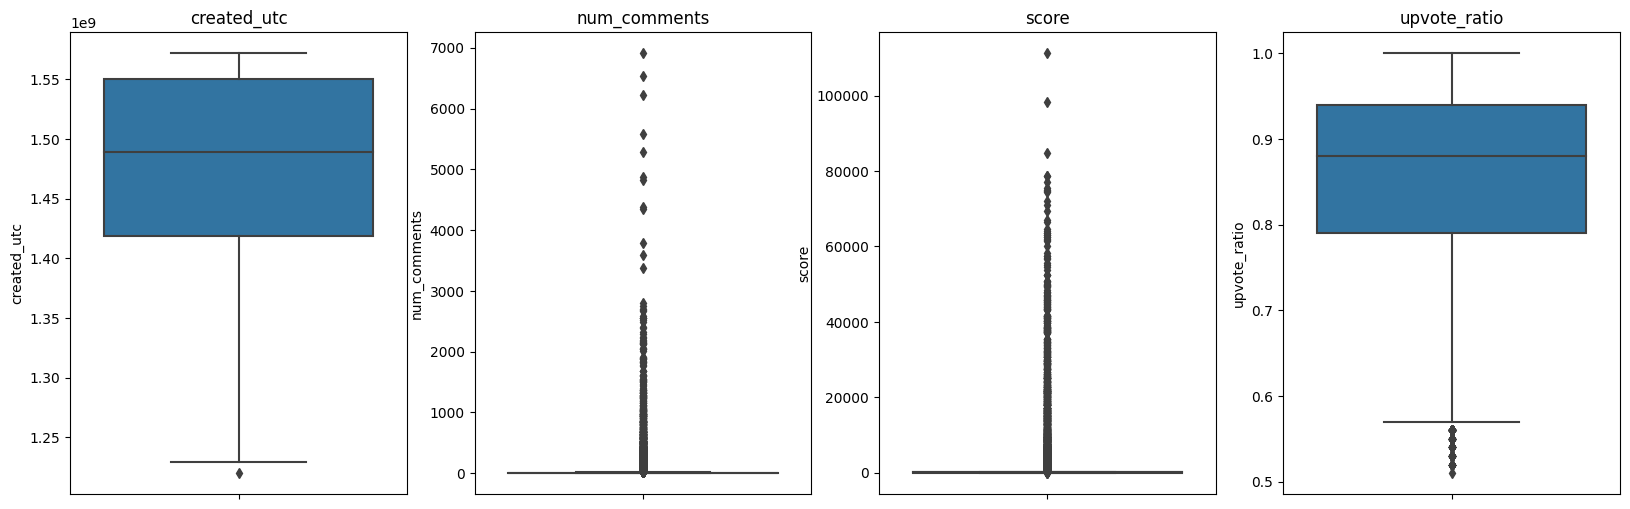

In [12]:
# Asumiendo que 'df' es tu DataFrame y ya tiene las columnas necesarias.

# Lista de columnas numéricas para graficar
numerical_columns = ['created_utc', 'num_comments', 'score', 'upvote_ratio']
plt.figure(figsize=(20, 6))  # Ajuste las dimensiones para una mejor visualización vertical
# Crear un boxplot separado para cada variable numérica en orientación vertical
i=1
for col in numerical_columns:
    plt.subplot(1,4,i)
    sns.boxplot(y=df[col])  # Usa 'y' en lugar de 'x' para una orientación vertical
    plt.title(f'{col}')
    i+=1

plt.show()


- **created_utc**: La distribución es bastante ajustada, lo que sugiere que los tiempos de creación de estos artículos están dentro de un marco de tiempo relativamente estrecho. Hay algunos valores atípicos que fueron creados mucho antes que el resto.
- **num_comments**: Hay un rango significativo en el número de comentarios, con una concentración de artículos que tienen pocos comentarios y algunos artículos con un número muy alto de comentarios, que son los valores atípicos.
- **score**: La distribución está muy sesgada, con la mayoría de los artículos teniendo un puntaje bajo y algunos artículos con puntajes excepcionalmente altos, indicados por los valores atípicos.
- **upvote_ratio**: El diagrama de caja es bastante estrecho, lo que indica que la mayoría de los artículos tienen una proporción de votos positivos entre aproximadamente 0.6 y 1.0. Hay un grupo de artículos con una proporción de votos positivos más baja, visto como valores atípicos debajo del cuadro principal.


###**1.3. Distribución de la variable objetivo ('2_way_label')**

Se examina cómo se distribuyen las clases verdaderas y falsas. Si existe un desequilibrio significativo, se pueden necesitar técnicas de balanceo de clases para el modelo predictivo.

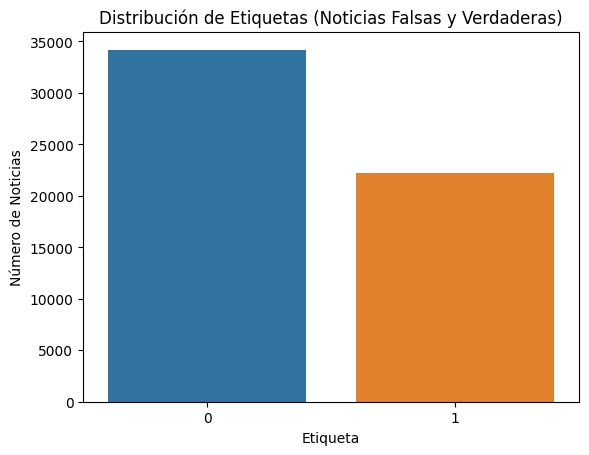

In [13]:
# Contar el número de noticias falsas y verdaderas
count_labels = df['2_way_label'].value_counts()

# Crear un gráfico de barras
sns.barplot(x=count_labels.index, y=count_labels.values)

# Personalizar el gráfico
plt.xlabel('Etiqueta')
plt.ylabel('Número de Noticias')
plt.title('Distribución de Etiquetas (Noticias Falsas y Verdaderas)')

# Mostrar el gráfico
plt.show()

La barra azul (etiqueta 0) representa la cantidad de noticias que han sido identificadas como falsas. Por otro lado, la barra naranja (etiqueta 1) muestra la cantidad de noticias que han sido verificadas como verdaderas. Se observa claramente que el número de noticias falsas supera al de las verdaderas en este conjunto de datos, lo cual es indicativo de una mayor prevalencia de noticias falsas en el conjunto de datos analizado.

Este tipo de gráfico permite identificar rápidamente desequilibrios. En la lucha contra la desinformación, entender esta distribución es crucial, ya que un conjunto de datos con un número desproporcionado de noticias falsas podría sesgar los resultados de modelos predictivos de aprendizaje automático.


**Score vs 2_way_label**

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


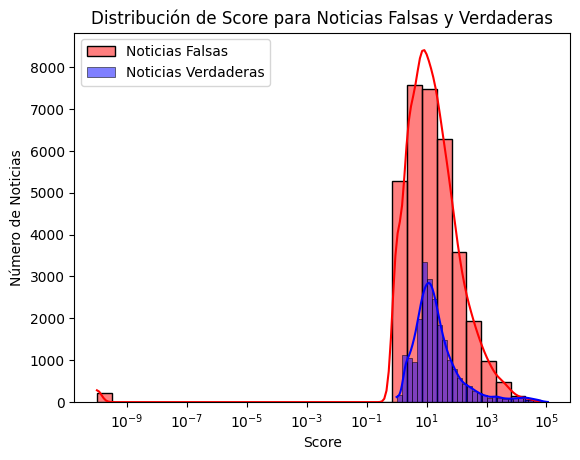

In [14]:
df['score'] += 0.0000000001
noticias_falsas = df[df['2_way_label'] == 0]
noticias_verdaderas = df[df['2_way_label'] == 1]
bins=30

# Crear histograma usando seaborn
sns.histplot(noticias_falsas['score'], bins=bins, color='red', label='Noticias Falsas', kde=True, log_scale=True)
sns.histplot(noticias_verdaderas['score'], bins=bins, color='blue', label='Noticias Verdaderas', kde=True, log_scale=True)
# Personalizar el gráfico
plt.xlabel('Score')
plt.ylabel('Número de Noticias')
plt.title('Distribución de Score para Noticias Falsas y Verdaderas')
plt.legend()
plt.show()

Se observa que hay una diferencia significativa en la distribución de scores entre las noticias falsas y las verdaderas. Las noticias falsas (en rojo) muestran una concentración más alta de scores bajos, mientras que las noticias verdaderas (en azul) tienen una distribución que tiende hacia scores ligeramente más altos. Esto se evidencia por el pico más pronunciado y desplazado hacia la derecha en el histograma azul.

**num_comments vs 2_way_label**

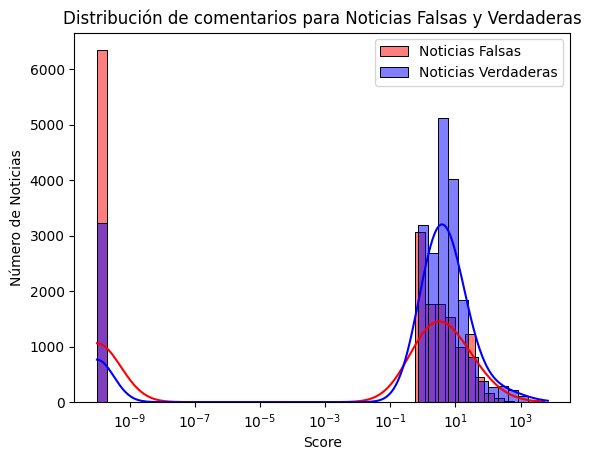

In [15]:
df['num_comments'] += 0.0000000001

noticias_falsas = df[df['2_way_label'] == 0]
noticias_verdaderas = df[df['2_way_label'] == 1]
bins=45

# Crear histograma usando seaborn
sns.histplot(noticias_falsas['num_comments'], bins=bins, color='red', label='Noticias Falsas', kde=True, log_scale=True)
sns.histplot(noticias_verdaderas['num_comments'], bins=bins, color='blue', label='Noticias Verdaderas', kde=True, log_scale=True)
# Personalizar el gráfico
plt.xlabel('Score')
plt.ylabel('Número de Noticias')
plt.title('Distribución de comentarios para Noticias Falsas y Verdaderas')
plt.legend()
plt.show()

**created_utc vs 2_way_label**

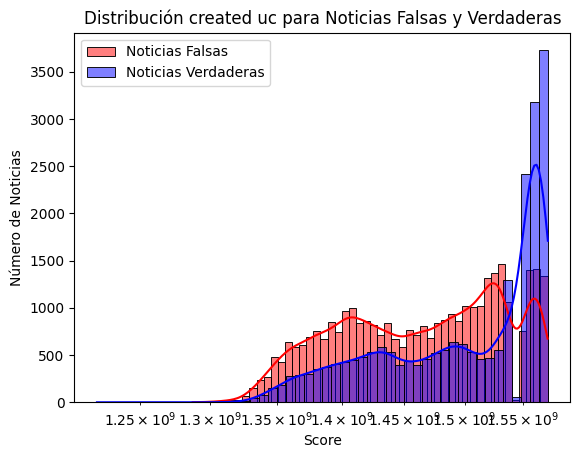

In [16]:
noticias_falsas = df[df['2_way_label'] == 0]
noticias_verdaderas = df[df['2_way_label'] == 1]

def plot(bins=20):
    # Crear histograma usando seaborn
    sns.histplot(noticias_falsas['created_utc'], bins=bins, color='red', label='Noticias Falsas', kde=True, log_scale=True)
    sns.histplot(noticias_verdaderas['created_utc'], bins=bins, color='blue', label='Noticias Verdaderas', kde=True, log_scale=True)
    # Personalizar el gráfico
    plt.xlabel('Score')
    plt.ylabel('Número de Noticias')
    plt.title('Distribución created uc para Noticias Falsas y Verdaderas')
    # Mostrar la leyenda
    plt.legend()
    # Mostrar el histograma
    plt.show()

plot(50)

**upvote_ratio vs 2_way_label**

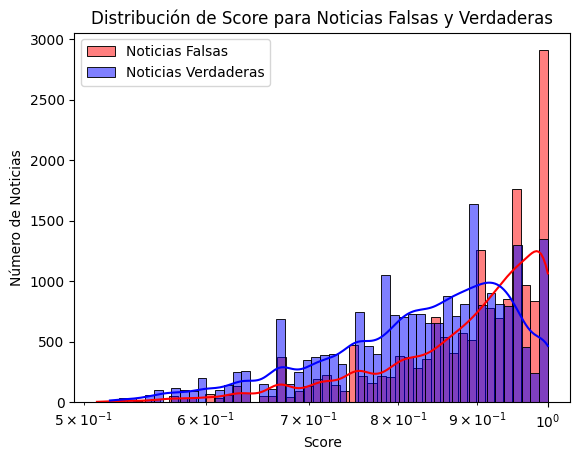

In [17]:
noticias_falsas = df[df['2_way_label'] == 0]
noticias_verdaderas = df[df['2_way_label'] == 1]

def plot(bins=20):
    # Crear histograma usando seaborn
    sns.histplot(noticias_falsas['upvote_ratio'], bins=bins, color='red', label='Noticias Falsas', kde=True, log_scale=True)
    sns.histplot(noticias_verdaderas['upvote_ratio'], bins=bins, color='blue', label='Noticias Verdaderas', kde=True, log_scale=True)
    # Personalizar el gráfico
    plt.xlabel('Score')
    plt.ylabel('Número de Noticias')
    plt.title('Distribución de Score para Noticias Falsas y Verdaderas')
    # Mostrar la leyenda
    plt.legend()
    # Mostrar el histograma
    plt.show()

plot(50)

###**1.4. Análisis de texto**

**Palabras mas frecuentes, bigramas, trigramas y analisis de sentimientos.**

Se realiza una exploración de los títulos limpios para identificar palabras clave comunes, bigramas/trigramas frecuentes, y posiblemente se lleva a cabo un análisis de sentimientos. Esto puede revelar patrones lingüísticos asociados con noticias verdaderas o falsas.

In [18]:
from collections import Counter
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Suponiendo que 'df' es su DataFrame y la columna 'clean_title' contiene los títulos de las noticias.

# Extraer la columna de títulos limpios
clean_titles = df['clean_title']

# Analizar las palabras más comunes
word_freq = Counter(" ".join(clean_titles).split()).most_common(10)

# Analizar bigramas y trigramas más comunes
bigrams_freq = Counter(ngrams(" ".join(clean_titles).split(), 2)).most_common(10)
trigrams_freq = Counter(ngrams(" ".join(clean_titles).split(), 3)).most_common(10)

# Análisis de sentimientos
sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(title) for title in clean_titles]

# Imprimir resultados
print(f"Palabras más comunes: {word_freq}")
print(f"Bigramas más comunes: {bigrams_freq}")
print(f"Trigramas más comunes: {trigrams_freq}")
print(f"Análisis de sentimientos (primeros 5 títulos): {sentiments[:5]}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Palabras más comunes: [('the', 16188), ('a', 12483), ('of', 8519), ('in', 7970), ('to', 7893), ('this', 7544), ('my', 4496), ('on', 4457), ('and', 3954), ('i', 3773)]
Bigramas más comunes: [(('in', 'the'), 1555), (('of', 'the'), 1457), (('on', 'the'), 969), (('looks', 'like'), 818), (('in', 'a'), 783), (('other', 'discussions'), 776), (('of', 'a'), 675), (('like', 'a'), 573), (('at', 'the'), 559), (('on', 'a'), 551)]
Trigramas más comunes: [(('looks', 'like', 'a'), 375), (('that', 'looks', 'like'), 127), (('the', 'way', 'this'), 101), (('in', 'front', 'of'), 92), (('one', 'of', 'the'), 82), (('out', 'of', 'the'), 78), (('the', 'first', 'time'), 72), (('for', 'the', 'first'), 71), (('the', 'way', 'the'), 70), (('i', 'found', 'a'), 70)]
Análisis de sentimientos (primeros 5 títulos): [{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'compound': 0.5859}, {'neg': 0.129, 'neu': 0.622, 'pos': 0.249, 'compound': 0.4019}, {'neg': 0.314, 'neu': 0.38

Para establecer un baseline en el análisis de texto, podemos comenzar con técnicas simples como conteo de frecuencia de palabras, bigramas y trigramas. Esto nos da una idea de los términos y frases más comunes, lo cual es un punto de partida para entender los datos.

- **Palabras más comunes**: Las palabras más comunes son principalmente artículos, preposiciones y pronombres ('the', 'a', 'of', 'in', 'to', 'this', 'my', 'on', 'and', 'i'). Estas palabras son muy comunes en el idioma inglés, pero no aportan mucho significado por sí solas (son conocidas como 'stop words').
- **Bigramas más comunes**: Los bigramas más comunes parecen seguir la misma tendencia que las palabras más comunes, incluyendo muchas 'stop words'. Sin embargo, hay combinaciones como ('looks', 'like') que podrían sugerir un patrón de lenguaje específico que merece más atención.
- **Trigramas más comunes**: Al igual que con los bigramas, los trigramas contienen muchas 'stop words'. Sin embargo, trigramas como ('looks', 'like', 'a') pueden ser parte de una frase que describe comparaciones o similitudes.
- **Análisis de sentimientos**: Se aplica el SentimentIntensityAnalyzer de NLTK para obtener una puntuación de sentimiento para los primeros cinco títulos muestra una mezcla de emociones. El primer título es neutro, el segundo y el quinto tienen una puntuación positiva, el tercero tiene una puntuación ligeramente positiva con una presencia notable de negatividad, y el cuarto es casi neutral con una leve inclinación negativa. Esto sugiere que los títulos varían en tono, lo que podría ser indicativo de diferentes tipos de noticias (por ejemplo, positivas, neutrales, negativas). El análisis de sentimientos puede ser útil para identificar la naturaleza emocional de los textos y, cuando se aplica a noticias, podría ayudar a detectar sesgos o tendencias en la forma en que se presentan las historias.

###**1.5. Tiempo de creación de los datos (`created_utc`)**

Se analiza si hay tendencias temporales en los datos, como eventos específicos que generaron picos de noticias falsas.

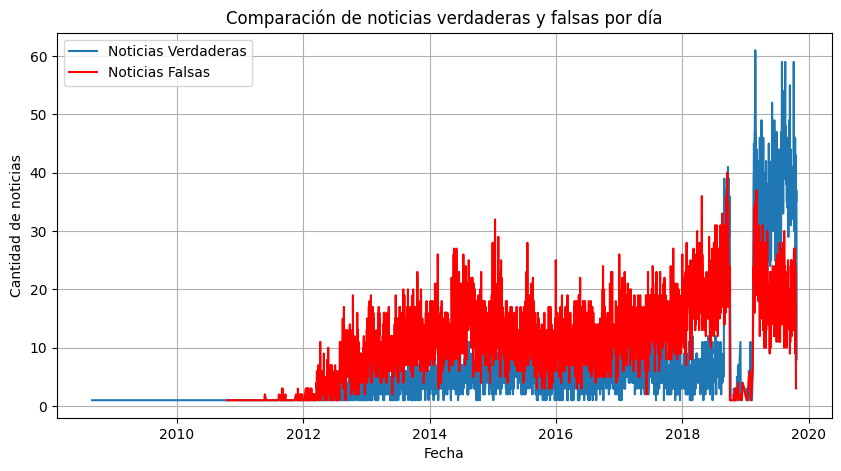

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'df' es su DataFrame y que ya ha sido cargado correctamente.

# Convertir las marcas de tiempo Unix 'created_utc' a un formato de fecha legible
df['created_date'] = pd.to_datetime(df['created_utc'], unit='s')

# Agrupar por fecha y contar la cantidad de noticias por día
news_counts_by_date = df.groupby(df['created_date'].dt.date).size()

# Si la columna '2_way_label' contiene información sobre si la noticia es verdadera o falsa,
# podemos dividir el conjunto de datos en dos para comparar las tendencias
true_news = df[df['2_way_label'] == 1]
false_news = df[df['2_way_label'] == 0]

# Contar la cantidad de noticias verdaderas y falsas por día

true_counts_by_date = true_news.groupby(true_news['created_date'].dt.date).size()
false_counts_by_date = false_news.groupby(false_news['created_date'].dt.date).size()

plt.figure(figsize=(10, 5))
# Crear un gráfico de líneas para comparar las tendencias de noticias verdaderas y falsas
true_counts_by_date.plot(kind='line', label='Noticias Verdaderas')
false_counts_by_date.plot(kind='line', label='Noticias Falsas', color='red')

plt.title('Comparación de noticias verdaderas y falsas por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de noticias')
plt.legend()
plt.grid(True)
plt.show()

Observamos que hay una cantidad fluctuante de noticias verdaderas y falsas a lo largo del tiempo. Sin embargo, hay un patrón notable en el que parece que la cantidad de noticias falsas (rojo) ha tenido un aumento significativo en ciertos períodos, especialmente antes del 2016 y posteriormente cerca del 2020. Esto podría coincidir con eventos globales importantes que podrían haber sido acompañados por un aumento en la difusión de noticias falsas.

Por otro lado, la cantidad de noticias verdaderas también muestra un aumento a través del tiempo, pero con un pico especialmente prominente cerca del año 2020. Esto podría deberse a un incremento en la cobertura de noticias durante eventos de gran interés público.

La superposición de las barras indica que en muchos días se reportaron tanto noticias verdaderas como falsas, lo que subraya la presencia constante de ambas en la circulación diaria de noticias.

Este tipo de visualización es útil para entender la dinámica temporal de la propagación de noticias y puede ser un punto de partida para investigaciones más detalladas sobre las causas de los picos en la difusión de noticias falsas y verdaderas.


###**1.6 Correlaciones**

<ipython-input-20-80f7c4d324b8>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


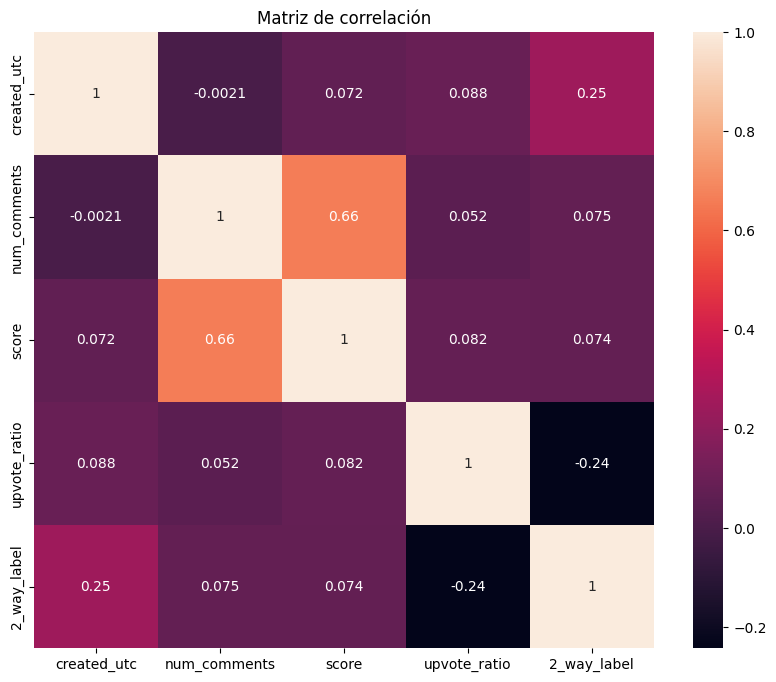

In [20]:
# Matriz de correlación y mapa de calor
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Matriz de correlación')
plt.show()


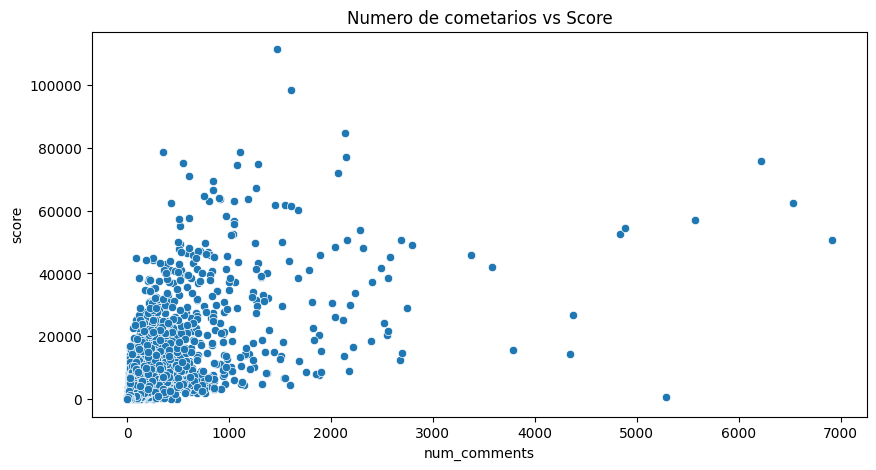

In [21]:
# Gráfico de dispersión entre 'num_comments' y 'score'
plt.figure(figsize=(10, 5))
sns.scatterplot(x='num_comments', y='score', data=df)
plt.title('Numero de cometarios vs Score')
plt.show()

Se observa una correlación positiva de 0.66 y la mayoría de los puntos están concentrados en la parte inferior izquierda del gráfico, lo que indica que la mayoría de las publicaciones tienen un número bajo de comentarios y un score bajo.

## **.BaseLine**

Funcion utilitaria para el dataset de imagenes

In [22]:
#Clase utilitaria para el dataset de imagenes
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.image_name = []

        # Recorre el directorio de datos para obtener las rutas de las imágenes y las etiquetas
        for label in os.listdir(root_dir):
            image_name = os.path.join(root_dir, label)
            try:
                _ = Image.open(image_name).convert("RGB")
                self.image_paths.append(image_name)
                self.image_name.append(label.replace('.jpg', ''))
            except Exception:
                pass

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = self.image_name[idx]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, image_name

Cargar y pasar a formato torch dataset de imagenes

In [24]:
# Ruta a la carpeta que contiene las imágenes etiquetadas
dataset_path = '/currdrive/images'


# Define las transformaciones que deseas aplicar a las imágenes
transform = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])

# Crea una instancia de tu conjunto de datos personalizado
custom_dataset = CustomImageDataset(root_dir=dataset_path, transform=transform)
dloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [25]:
# Función para mostrar una imagen
def show_image(img, title):
    # Si la imagen es un tensor de PyTorch, la convierte a formato de imagen de PIL
    if isinstance(img, torch.Tensor):
        img = transforms.ToPILImage()(img)
    plt.imshow(img)
    plt.title(title)
    plt.show()

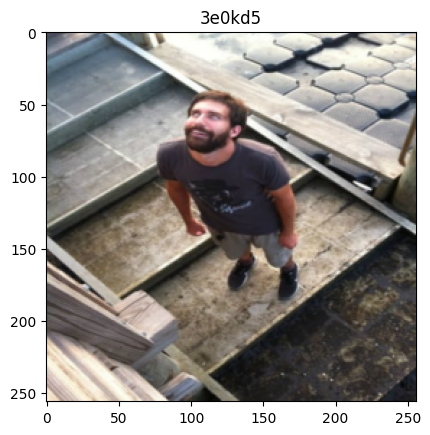

In [26]:
images, names = next(iter(dloader))

# Mostrar la primera imagen del lote
show_image(images[1], names[1])

##**2.Modelos**

Nuestra aplicación sera capaz de capturar inputs en forma de datos tabulares, imagenes y texto.

###**2.1. Modelos para datos tabulares**

Importar librerias

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split

Obtener datos numericos de los datos tabulares

In [28]:
df_tab = df.copy()

#Dataset tabular con solo las variables numericas
df_tab = df_tab[['num_comments', 'score', 'upvote_ratio', '2_way_label']]
df_tab= df_tab[~df_tab['num_comments'].isna()]
X = df_tab[['num_comments', 'score', 'upvote_ratio']]
y = df_tab['2_way_label']

Datos faltantes

In [29]:
#Visualizar datos faltantes
X.isna().sum()

num_comments    0
score           0
upvote_ratio    0
dtype: int64

Division del dataset tabular en train y test

In [30]:
#Division del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Predicciones y metricas

In [31]:
#Función de métricas y matriz de confusión
def evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    df_metric = pd.DataFrame([{
    'Model name': model_name,
    'Accuracy': accuracy_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Fbeta Score': fbeta_score(y_test, y_pred, beta=0.7)
    }])

    print(f"métricas:\n{df_metric}\n")

    #matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=model.classes_
    )

    disp.plot()
    plt.show()
    return y_pred, df_metric

**Regresión logistica**

métricas:
            Model name  Accuracy    Recall  Precision  F1 Score  Fbeta Score
0  Logistic Regression  0.651735  0.731042   0.680636  0.704939     0.696428



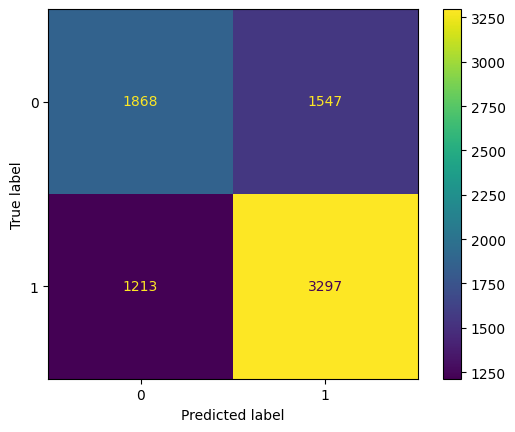

In [32]:
model1 = LogisticRegression(random_state=42)
predict1, metric1 = evaluate(model1,'Logistic Regression')

**Calsificador MLP**

métricas:
       Model name  Accuracy    Recall  Precision  F1 Score  Fbeta Score
0  MLP Classifier  0.687192  0.655876    0.76139  0.704705     0.723132



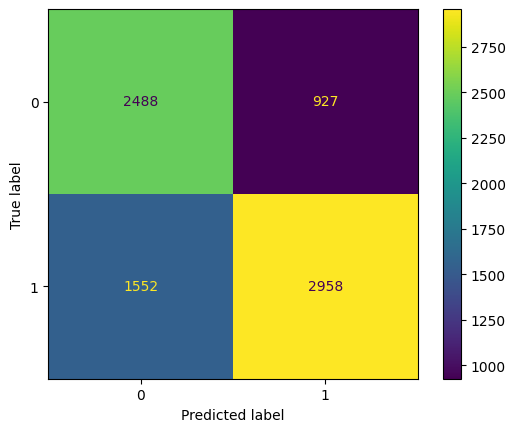

In [33]:
model2 = MLPClassifier(random_state=1, max_iter=300)
predict2, metric2 = evaluate(model2,'MLP Classifier')

**Random Forest**



métricas:
      Model name  Accuracy    Recall  Precision  F1 Score  Fbeta Score
0  Random Forest  0.700694  0.717073   0.746882  0.731674     0.736809



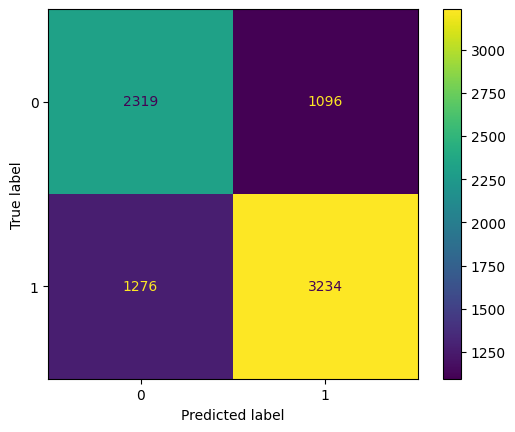

In [34]:
model3 = RandomForestClassifier(n_estimators=10)
predict3,metric3=evaluate(model3, 'Random Forest')

**Gradient Boosting Classifier**

métricas:
          Model name  Accuracy    Recall  Precision  F1 Score  Fbeta Score
0  Gradient Boosting  0.692871  0.731707   0.729443  0.730573     0.730186



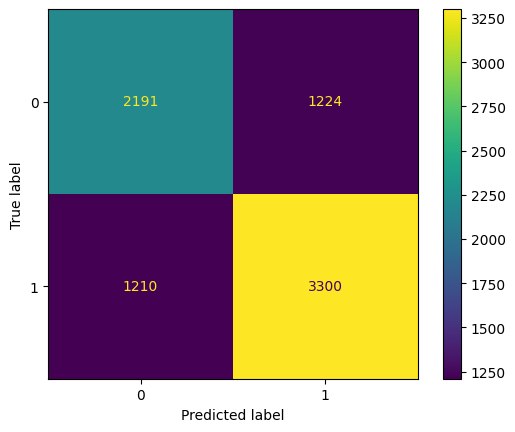

In [35]:
model4 = GradientBoostingClassifier(n_estimators=10)
predict4,metric4=evaluate(model4, 'Gradient Boosting')

In [36]:
df_resumen = pd.concat([metric1, metric2, metric3, metric4], ignore_index=True)
df_resumen

,Model name,Accuracy,Recall,Precision,F1 Score,Fbeta Score
0,Logistic Regression,0.651735,0.731042,0.680636,0.704939,0.696428
1,MLP Classifier,0.687192,0.655876,0.761390,0.704705,0.723132
2,Random Forest,0.700694,0.717073,0.746882,0.731674,0.736809
3,Gradient Boosting,0.692871,0.731707,0.729443,0.730573,0.730186


###**2.2. Modelos imagenes**

**Visual Transformer**

Importar librerias

In [ ]:
! pip install -U accelerate
! pip install -U transformers
! pip install evaluate

In [38]:
import pandas as pd
import numpy as np
import torch
from PIL import Image
from datasets import Dataset, Image,load_metric
from transformers import AutoImageProcessor,ViTForImageClassification,TrainingArguments,Trainer

Verficamos si podemos abrir alguna imagen

In [ ]:
!ls '/currdrive/images'

In [43]:
try:
  img = Image.open('/content/drive/MyDrive/000 MIA UC/Proyecto Aplicado/Proyecto/images/101iz8.jpg')
  img.show()
except Exception as e:
  print("Error:", e)

Error: type object 'Image' has no attribute 'open'


Carga de imagenes

In [ ]:
def file_check(x):
    try:
        img = Image.open(f'/currdrive/images/{x}.jpg')
        return img.mode
    except:
        return False

In [ ]:
#copiar df anterior
df_img = df.copy()

In [ ]:
#encontrar imagenes en dasaet
df_img['has_image'] = df_img['id'].apply(file_check)

In [ ]:
from multiprocessing import Pool
# Crear un pool de procesos y mapear la función file_check a los IDs de imagen
with Pool(processes=4) as pool:
    df_img['has_image'] = pool.map(file_check, df_img['id'])

In [ ]:
df_img.groupby('has_image').count()

,clean_title,created_utc,id,image_url,linked_submission_id,num_comments,score,upvote_ratio,2_way_label,created_date
has_image,,,,,,,,,,
False,56400,56400,56400,56265,16779,39621,56400,39621,56400,56400


In [ ]:
df_images= df_img[df_img['has_image'] == 'RGB']
df_images['image']=df_images['id'].apply(lambda x: f'images/{x}.jpg')
df_images['labels']=df_images['2_way_label']

df_img= df_images [['image', 'labels']]
df_img.describe()

,labels
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [ ]:
df_img['image'].describe()

Division del dataset tabular en train y test

In [ ]:
#Div
image_dataset = Dataset.from_pandas(df_img) \
    .cast_column('image', Image()) \
    .train_test_split(test_size=0.2)
image_dataset

**Visual transformer (VIT)**

In [ ]:
#Procesar modelo nase
model_id = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_id)

In [ ]:
# funcion para carga de imagenes por batch
def transform(example_batch):
  inputs = image_processor([x for x in example_batch["image"]], return_tensors="pt")
  inputs["labels"] = example_batch["labels"]
  return inputs

In [ ]:
#prearar dataset
prepared_ds = image_dataset.with_transform(transform)

In [ ]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch])
  }

In [ ]:
#metrica de evaluación
metric = load_metric("accuracy")

def compute_metrics(prediction):
  return metric.compute(
    predictions=np.argmax(prediction.predictions, axis=1),
    references=prediction.label_ids
)

Modelo

In [ ]:
model_vt = ViTForImageClassification.from_pretrained(
    model_id,
    num_labels=2,
    # id2label={str(i): c for i, c in enumerate(labels)},
    # label2id={c: str(i) for i,c in enumerate(labels)}
)

Entrenamiento

In [ ]:
training_args_vt = TrainingArguments(
    output_dir="./image_model",
    evaluation_strategy="steps",
    num_train_epochs=4,
    learning_rate=2e-4,
    load_best_model_at_end=True,
    remove_unused_columns=False,
)

In [ ]:
image_dataset["train"].features

In [ ]:
trainer_vt = Trainer(
    model=model_vt,
    args=training_args_vt,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=image_processor
)

In [ ]:
train_results_vt = trainer_vt.train()
trainer_vt.save_model()
trainer_vt.log_metrics("train", train_results_vt.metrics)
trainer_vt.save_metrics("train", train_results_vt.metrics)

Evaluacion

In [ ]:
metrics_vt = trainer_vt.evaluate(prepared_ds["test"])
trainer_vt.log_metrics("eval", metrics_vt)
trainer_vt.save_metrics("eval", metrics_vt)

###**2.3. Modelo de texto**

Importar librerias

In [ ]:
! pip install -U accelerate
! pip install -U transformers
! pip install evaluate

In [55]:
import numpy as np
import torch
import evaluate
from transformers import AutoTokenizer,DataCollatorWithPadding,AutoModelForSequenceClassification,TrainingArguments,Trainer
from datasets import Dataset, Image,load_metric

Definir dataset de texto

In [56]:
#definir dataframe de texto con variables de interes
df_txt= df.copy()
df_txt['label'] = df_txt['2_way_label']
df_txt = df_txt[['clean_title', 'label']]

Separar conjunto de entrenamiento y test

In [57]:
#separar conjunto de entrenamiento y test
text_dataset = Dataset.from_pandas(df_txt) \
    .train_test_split(test_size=0.2)

text_dataset

DatasetDict({
    train: Dataset({
        features: ['clean_title', 'label'],
        num_rows: 45120
    })
    test: Dataset({
        features: ['clean_title', 'label'],
        num_rows: 11280
    })
})

Tokenizar

In [58]:
#Tokenizar el texto
repo_id = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(repo_id)

(…)tilroberta-base/resolve/main/config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

(…)stilroberta-base/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…)stilroberta-base/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)roberta-base/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [59]:
#funcion utilizatria para tokenizar
def tokenize_fn(example):
  return tokenizer(example["clean_title"], truncation=True, return_tensors='pt', padding=True)

In [ ]:
text_dataset = text_dataset.map(tokenize_fn, batched=True)
text_dataset = text_dataset.map(lambda x: x, batched=True, remove_columns=['clean_title'])

Map:   0%|          | 0/45120 [00:00<?, ? examples/s]

Map:   0%|          | 0/11280 [00:00<?, ? examples/s]

Map:   0%|          | 0/45120 [00:00<?, ? examples/s]

Map:   0%|          | 0/11280 [00:00<?, ? examples/s]

In [60]:
print(text_dataset['train'][0])

{'clean_title': 'qb ryan fitzpatrick after a touchdown', 'label': 1}


In [61]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Metricas

In [62]:
#Definir metricas
# Cargar la métrica fbeta
#from evaluate import load
#fbeta_metric = load("fbeta", beta=0.7)  # Puedes cambiar beta según tus necesidades

clf_metrics = evaluate.combine(["accuracy","recall", "precision","f1"])

In [63]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return clf_metrics.compute(predictions=predictions, references=labels)

Modelo

In [64]:
#Definir el modelo
model_txt = AutoModelForSequenceClassification.from_pretrained(repo_id,num_labels=2,)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entrenamiento

In [65]:
#Parametros de entrenamiento
training_args_txt = TrainingArguments(
    output_dir = "./text_model",
    evaluation_strategy="steps",
    num_train_epochs=1,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    no_cuda=False,
)

In [66]:
#Configurar el entrenamiento
trainer_txt = Trainer(
    model_txt,
    training_args_txt,
    train_dataset=text_dataset["train"],
    eval_dataset=text_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
train_results_txt = trainer_txt.train()
trainer_txt.save_model()
trainer_txt.log_metrics("train", train_results_txt.metrics)
trainer_txt.save_metrics("train", train_results_txt.metrics)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
500,0.527900,0.466342,0.793794,0.639194,0.799664,0.710480
1000,0.476700,0.412239,0.817996,0.691153,0.820745,0.750395
1500,0.446800,0.412423,0.819681,0.834267,0.742180,0.785534
2000,0.438300,0.398770,0.813475,0.645017,0.847308,0.732452
2500,0.420500,0.395157,0.819947,0.657559,0.853985,0.743009
3000,0.423200,0.400581,0.828901,0.828219,0.760749,0.793052
3500,0.404100,0.442819,0.832004,0.856887,0.752853,0.801508
4000,0.387700,0.403200,0.835727,0.834938,0.769612,0.800945
4500,0.381800,0.380322,0.845390,0.786562,0.816175,0.801095
5000,0.380300,0.395598,0.846809,0.814110,0.801897,0.807957


***** train metrics *****
  epoch                    =        1.0
  total_flos               =   980854GF
  train_loss               =     0.4239
  train_runtime            = 0:11:43.52
  train_samples_per_second =     64.134
  train_steps_per_second   =      8.017


Evaluacion del modelo

In [ ]:
metrics_txt = trainer_txt.evaluate(text_dataset["test"])
trainer_txt.log_metrics("eval", metrics_txt)
trainer_txt.save_metrics("eval", metrics_txt)

***** eval metrics *****
  epoch                   =        1.0
  eval_accuracy           =     0.8454
  eval_f1                 =     0.8011
  eval_loss               =     0.3803
  eval_precision          =     0.8162
  eval_recall             =     0.7866
  eval_runtime            = 0:00:18.45
  eval_samples_per_second =    611.339
  eval_steps_per_second   =     76.417


##**3. Front End**

###**3.1. Streamlit**

In [ ]:
# Instalamos las librerías
!pip install streamlit
!pip install pyngrok==4.1.1
!pip install pipreqs

In [ ]:
!pipreqs . --force

In [46]:
%%writefile VeritasCorp.py

import streamlit as st # Importando la biblioteca Streamlit para crear la aplicación web

st.set_page_config(
    page_title="VeritasCorp",
    page_icon="✨",
    layout="wide"
)

st.title("✨ VeritasCorp")

st.info("""
Prototype created for VeritasCorp to distinguish Fabulas
from real news. This prototype is multipolar and
flexible, supports text inputs, images and
other news details such as number of comments,
score and others.
""")

left, right = st.columns(2)

with right:
    image_upload = st.file_uploader(
        "Upload the image of the news",
        type=['jpg', 'png', 'jpeg']
    )

    if image_upload:
        with st.expander(
            'See uploaded image',
            expanded=False
        ):
            st.image(image_upload)

with left:
    text = st.text_input('Write the text of the news', '')
    comments = st.number_input('How many comments does the news have?')
    radio = st.number_input('What is the news up-radio?')
    score = st.number_input('What is the news score?')


if st.button('Analyze', disabled=not (
    image_upload and text and comments and radio and score
)):
    pass

Writing VeritasCorp.py


In [47]:
# Check files in directory
!ls

drive  sample_data  VeritasCorp.py


In [48]:
!cat /root/.ngrok2/ngrok.yml


cat: /root/.ngrok2/ngrok.yml: No such file or directory


###**3.2. Ejecutando la APP localmente usando ngrok**

In [49]:
!ngrok authtoken 2YHDs8zAfrFdwwtOpIGxt2MdFcL_6wckFbXCRVb1D8JgkF7vZ

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [50]:
#verificamos ngrok
!ngrok

NAME:
   ngrok - tunnel local ports to public URLs and inspect traffic

DESCRIPTION:
    ngrok exposes local networked services behinds NATs and firewalls to the
    public internet over a secure tunnel. Share local websites, build/test
    webhook consumers and self-host personal services.
    Detailed help for each command is available with 'ngrok help <command>'.
    Open http://localhost:4040 for ngrok's web interface to inspect traffic.

EXAMPLES:
    ngrok http 80                    # secure public URL for port 80 web server
    ngrok http -subdomain=baz 8080   # port 8080 available at baz.ngrok.io
    ngrok http foo.dev:80            # tunnel to host:port instead of localhost
    ngrok http https://localhost     # expose a local https server
    ngrok tcp 22                     # tunnel arbitrary TCP traffic to port 22
    ngrok tls -hostname=foo.com 443  # TLS traffic for foo.com to port 443
    ngrok start foo bar baz          # start tunnels from the configuration file

VERSI

In [51]:
from pyngrok import ngrok

In [52]:
# Run app on the background
!streamlit run VeritasCorp.py&>/dev/null&

In [53]:
!pgrep streamlit

32781


In [54]:
# Create a public url for the developer to run the app at the web locally
public_url = ngrok.connect(port='8501')
public_url

'http://9b9c-35-234-48-145.ngrok-free.app'